Copyright 2021 NVIDIA Corporation. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: center;">

# Triton server with FIL backend

## Overview

This notebook shows the procedure to deploy a [XGBoost model](https://xgboost.readthedocs.io/en/latest/) in Triton Inference Server with Forest Inference Library (FIL) backend. The FIL backend allows forest models trained by several popular machine learning frameworks (including XGBoost, LightGBM, Scikit-Learn, and cuML) to be deployed in a Triton inference server using the RAPIDS Forest Inference LIbrary for fast GPU-based inference. Using this backend, forest models can be deployed seamlessly alongside deep learning models for fast, unified inference pipelines.

### Contents
* [Train XGBoost model on dummy data](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Train-XGBoost-model)
* [Export, load and deploy XGBoost model in Triton Inference Server](http://localhost:8888/notebooks/simple_xgboost_example.ipynb#Export,-load-and-deploy-XGBoost-model-in-Triton-Inference-Server)
* [Determine throughput and latency using Perf Analyzer](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Determine-throughput-and-latency-with-Perf-Analyzer)
* [Find best configuration using Model Analyzer](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Find-best-configuration-using-Model-Analyzer)
* [Deploy model with best configuration](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Deploy-model-with-best-configuration)
* [Triton Client](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Triton-Client)
* [Conclusion](http://localhost:7001/notebooks/simple_xgboost_example.ipynb#Conclusion)

## Requirements

* Nvidia GPU (Pascal+ Recommended GPUs: T4, V100 or A100)
* [Latest NVIDIA driver](https://docs.nvidia.com/datacenter/tesla/tesla-installation-notes/index.html)
* [Docker](https://docs.docker.com/get-docker/)
* [The NVIDIA container toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker)

## Setup

To begin, check that the NVIDIA driver has been installed correctly. The `nvidia-smi` command should run and output information about the GPUs on your system:"

In [ ]:
!nvidia-smi

## Install XGBoost and Sklearn

We'd need to install XGBoost and SKlearn using the following pip3 commands inside the container as follows:

In [ ]:
# Install sklearn and XGBoost
!pip3 install -U scikit-learn xgboost

## Train XGBoost model

If you have a pre-trained xgboost model, save it as `xgboost.model` and skip this step. We'll train a XGBoost model on random data in this section 

In [ ]:
# Import required libraries
import numpy
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import signal
import subprocess

In [ ]:
# Generate dummy data to perform binary classification
seed = 7
features = 9 # number of sample features
samples = 10000 # number of samples
X = numpy.random.rand(samples, features).astype('float32')
Y = numpy.random.randint(2, size=samples)

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}".format(accuracy * 100.0))

## Export, load and deploy XGBoost model in Triton Inference Server

For deploying the trained XGBoost model in Triton Inference Server, follow the steps below:

**1. Create a model repository and save xgboost model checkpoint:**

We'll need to create a model repository that looks as follows:

```
model_repository/
`-- fil
    |-- 1
    |   `-- xgboost.model
    `-- config.pbtxt
```

In [ ]:
# Create directory to save the model
![ ! -d "/model_repository" ] && mkdir -p /model_repository/fil/1

# Save your xgboost model as xgboost.model
# For more information on saving xgboost model check https://xgboost.readthedocs.io/en/latest/python/python_intro.html#training
# Model can also be dumped to json format
model.save_model('/model_repository/fil/1/xgboost.model')

**Note:**
The FIL backend's testing infrastructure includes a script for generating example models, putting them in the correct directory layout, and generating an associated config file. This can be helpful both for providing a template for your own models and for testing your Triton deployment. Please check this [link](https://github.com/triton-inference-server/fil_backend/blob/main/Example_Models.md) for the sample script.

**2. Create and save config.pbtxt**

To deploy the model in Triton Inference Server, we need to create and save a protobuf config file called config.pbtxt under `model_repository/fil/` directory that contains information about the model and the deployment. Sample config file is available here: [link](https://github.com/triton-inference-server/fil_backend#configuration)

Essentially, the following parameters need to be updated as per your configuration

```
name: "fil"                              # Name of the model directory (fil in our case)
backend: "fil"                           # Triton FIL backend for deploying forest models
max_batch_size: 8192
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 9 ]                          # Input feature dimensions, in our sample case it's 9
  }
]
output [
 {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 1 ]                          # Output 2 for binary classification model
  }
]
instance_group [{ kind: KIND_GPU }]
parameters [
  {
    key: "model_type"
    value: { string_value: "xgboost" }
  },
  {
    key: "predict_proba"
    value: { string_value: "false" }
  },
  {
    key: "output_class"
    value: { string_value: "true" }
  },
  {
    key: "threshold"
    value: { string_value: "0.5" }
  },
  {
    key: "algo"
    value: { string_value: "ALGO_AUTO" }
  },
  {
    key: "storage_type"
    value: { string_value: "AUTO" }
  },
  {
    key: "blocks_per_sm"
    value: { string_value: "0" }
  }
]
```

Triton server looks for this configuration file before deploying XGBoost model for inference. It'll setup the server parameters as per the configuration passed within config.pbtxt. Store the above config at `/model_repository/fil/` directory as config.pbtxt as follows:

For more information on sample configs, please refer this [link](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md)

In [ ]:
%%bash
# Writing config to file
cat > /model_repository/fil/config.pbtxt <<EOL 
name: "fil"                              # Name of the model directory (fil in our case)
backend: "fil"                           # Triton FIL backend for deploying forest models
max_batch_size: 8192
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 9 ]                          # Input feature dimensions, in our sample case it's 9
  }
]
output [
 {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 1 ]                          # Output 2 for binary classification model
  }
]
instance_group [{ kind: KIND_GPU }]
parameters [
  {
    key: "model_type"
    value: { string_value: "xgboost" }
  },
  {
    key: "predict_proba"
    value: { string_value: "false" }
  },
  {
    key: "output_class"
    value: { string_value: "true" }
  },
  {
    key: "threshold"
    value: { string_value: "0.5" }
  },
  {
    key: "algo"
    value: { string_value: "ALGO_AUTO" }
  },
  {
    key: "storage_type"
    value: { string_value: "AUTO" }
  },
  {
    key: "blocks_per_sm"
    value: { string_value: "0" }
  }
]

EOL

The model repository should look like this:

```
model_repository/
`-- fil
    |-- 1
    |   `-- xgboost.model
    `-- config.pbtxt
```

**3. Deploy the model in Triton Inference Server**

Finally, we can deploy the xgboost model in Triton Inference Server using the following command:

In [ ]:
# Run the Triton Inference Server in a Subprocess from Jupyter notebook

triton_process = subprocess.Popen(["tritonserver", "--model-repository=/model_repository"], stdout=subprocess.PIPE, preexec_fn=os.setsid) 

The above command should load the model and print the log `successfully loaded 'fil' version 1`. Triton server listens on the following endpoints:

```
Port 8000    -> HTTP Service
Port 8001    -> GRPC Service
Port 8002    -> Metrics
```

We can test the status of the server connection by running the curl command: `curl -v <IP of machine>:8000/v2/health/ready` which should return `HTTP/1.1 200 OK`

**NOTE:-** In our case the IP of machine on which Triton Server and this notebook are currently running is `localhost`

In [ ]:
!curl -v localhost:8000/v2/health/ready

## Determine throughput and latency with Perf Analyzer

Once the model is deployed for inference in Triton, we can measure its inference performance using `perf_analyzer`. The perf_analyzer application generates inference requests to the deployed model and measures the throughput and latency of those requests. For more information on `perf_analyzer` utility, please refer this [link](https://github.com/triton-inference-server/server/blob/main/docs/perf_analyzer.md) 

In [ ]:
# Install nvidia-pyindex
!pip3 install nvidia-pyindex

In [ ]:
# Install Triton client
!pip3 install tritonclient[http]

In [ ]:
# Run Perf analyzer to simulate incoming inference requests to Triton server
# Stabilize p99 latency with threshold of 5 msec and concurrency of incoming request from 10 to 15 with batch size 1
!perf_analyzer -m fil --percentile=99 --latency-threshold=5 --concurrency-range=10:15 --async -b 1

In [ ]:
# Stopping Triton Server before proceeding further
os.killpg(os.getpgid(triton_process.pid), signal.SIGTERM)  # Send the signal to all the process groups

## Find best configuration using Model Analyzer

[Triton Model Analyzer](https://github.com/triton-inference-server/model_analyzer) is a tool to profile and evaluate the best deployment configuration that maximizes inference performance of your model when deployed in Triton Inference Server. Using this tool, you can find the appropriate batch size, instances of your model etc. based on the constraints specified like maximum latency budget, minimum throughput and maximum GPU utilization limit. Model Analyzer installation steps are available here: [link](https://github.com/triton-inference-server/model_analyzer/blob/main/docs/install.md)

In [ ]:
# Install library
!pip3 install triton-model-analyzer

Create a config file specifying the profiling constrains as follows:
* `perf_throughput` - Specify minimum desired throughput.


* `perf_latency` - Specify maximum tolerable latency or latency budget.


* `gpu_used_memory` - Specify maximum GPU memory used by model.

In [ ]:
%%bash
# Writing constraints to file
cat > model_analyzer_constraints.yaml <<EOL 
model_repository: /model_repository/
triton_launch_mode: "local"
latency_budget: 5
run_config_search_max_concurrency: 64
run_config_search_max_instance_count: 3
run_config_search_max_preferred_batch_size: 8
profile_models:
  fil

EOL

In [ ]:
# Run model_analyzer profiler on XGBoost model 
!model-analyzer profile -f model_analyzer_constraints.yaml --override-output-model-repository

The above command will perform a search across various config parameters on the `fil` XGBoost model. Complete execution of this cell might take a while (30-40 mins) as the model analyzer searches for the optimum configuration based on the given constraints. When finished, model analyzer stores all of the profiling measurements it has taken in a binary file in the checkpoint directory. Now we can generate and visualize results using `analyze` command as follows:

In [ ]:
# Install wkhtmltopdf to generate pdf reports
!apt-get update && apt-get install -y wkhtmltopdf

In [ ]:
![ ! -d "analysis_results" ] && mkdir analysis_results
!model-analyzer analyze --analysis-models fil -e analysis_results

The detailed summary report from model analyzer can be found under `/notebook/analysis_results/reports/summaries/fil/result_summary.pdf`. It'll look something like this:

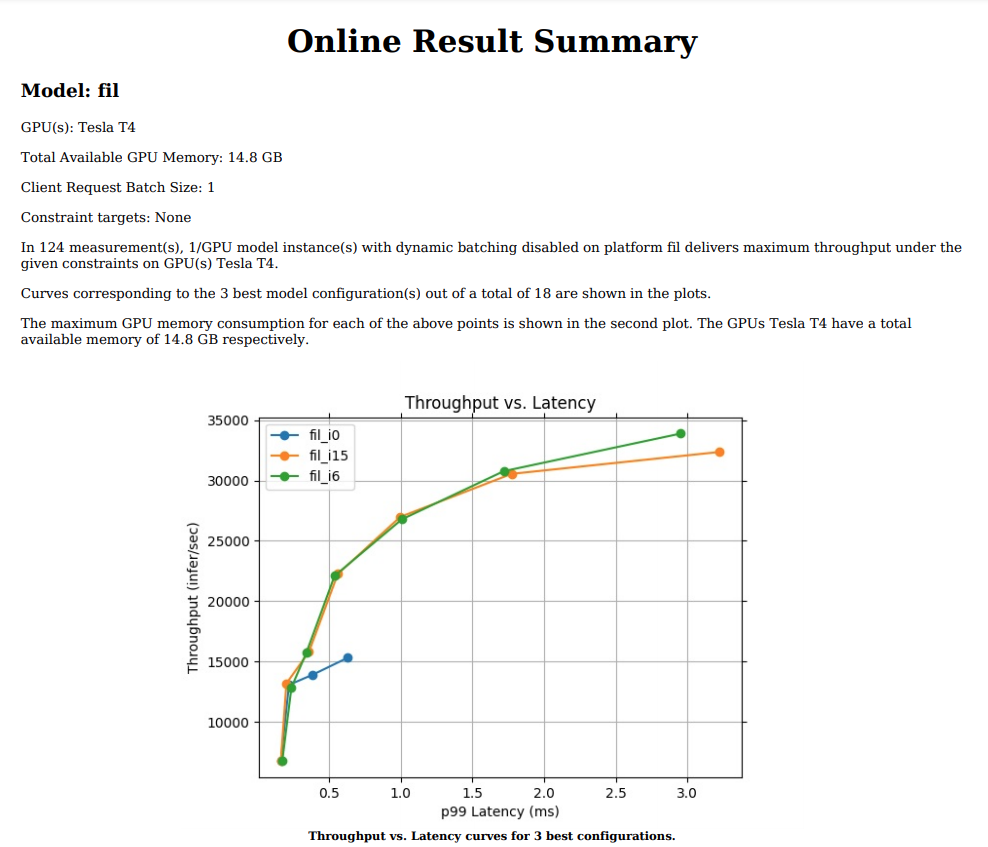

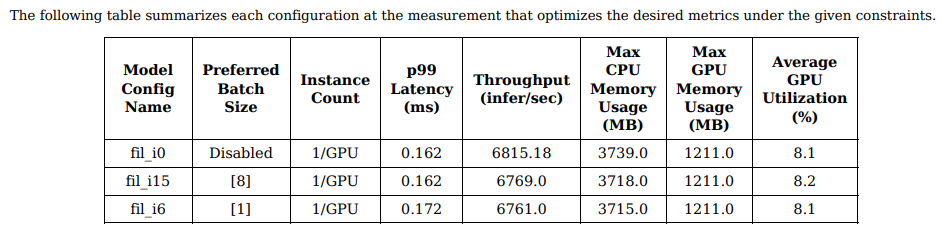

## Deploy model with best configuration

Now we can deploy the model with configuration that gives best throughput and latency numbers as evaluated by the model analyzer. In our case, model configuration `fil_config0` gives the best configuration. We can now copy this config.pbtxt to model directory and re-deploy Triton Inference Server  

In [ ]:
%%bash
# Change the best model configuration as per required constraints
export best_model='fil_config0'
cp -r output_model_repository/$best_model/ /model_repository/
mkdir -p /model_repository/$best_model/1 && cp /model_repository/fil/1/xgboost.model /model_repository/$best_model/1/

In [ ]:
# Run Triton Inference Server in background from Jupyter notebook

triton_process = subprocess.Popen(["tritonserver", "--model-repository=/model_repository"], stdout=subprocess.PIPE, preexec_fn=os.setsid) 

In [ ]:
# Run the perf_analyzer with same parameters
# Change the model as per your configuration 
!perf_analyzer -m fil_config0 --percentile=99 --latency-threshold=5 --concurrency-range=10:15 --async -b 1

In [ ]:
# Stopping Triton Server before proceeding further
os.killpg(os.getpgid(triton_process.pid), signal.SIGTERM)  # Send the signal to all the process groups

## Triton Client

After model profiling is done and the final model is selected as per required configuration and deployed in Triton, we can now test the inference by sending real inference request from Triton Client and checking the accuracy of responses. For more information on installation steps, please check [Triton Client Github](https://github.com/triton-inference-server/client)  

In [ ]:
# Run Triton Inference Server in background from Jupyter notebook

triton_process = subprocess.Popen(["tritonserver", "--model-repository=/model_repository"], stdout=subprocess.PIPE, preexec_fn=os.setsid) 

In [ ]:
# Check client library can be imported
import numpy
import tritonclient.http as triton_http

In [ ]:
# Set up HTTP client.
http_client = triton_http.InferenceServerClient(
    url='localhost:8000',
    verbose=False,
    concurrency=1
)

# Set up Triton input and output objects for both HTTP and GRPC
triton_input_http = triton_http.InferInput(
    'input__0',
    (X_test.shape[0], X_test.shape[1]),
    'FP32'
)
triton_input_http.set_data_from_numpy(X_test, binary_data=True)
triton_output_http = triton_http.InferRequestedOutput(
    'output__0',
    binary_data=True
)

# Submit inference requests 
request_http = http_client.infer(
    'fil',
    model_version='1',
    inputs=[triton_input_http],
    outputs=[triton_output_http]
)

# Get results as numpy arrays
result_http = request_http.as_numpy('output__0')

# Check that we got the same accuracy as previously
accuracy = accuracy_score(y_test, result_http)
print("Accuracy: {:.2f}".format(accuracy * 100.0))

The above test accuracy score of the model deployed in Triton using FIL backend matches with the one previously computed using XGBoost library's predict function.

In [ ]:
# Stopping Triton Server before proceeding further
os.killpg(os.getpgid(triton_process.pid), signal.SIGTERM)  # Send the signal to all the process groups

# Conclusion

Triton FIL backend can be used for deploying tree based models trained in frameworks like LightGBM, Scikit-Learn, and cuML for fast GPU-based inference. Essentially, tree based models can now be deployed with other deep learning based models in Triton Inference Server seamlessly. Moreover, Model Analyzer utility tool can be used to profile the models and get the best deployment configuration that satisfy the deployment constraints. The trained model can then be deployed using the best configuration in Triton and Triton Client can be used for sending inference requests. 